## Keras implementation of https://phillipi.github.io/pix2pix
## 字型變換

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'

設定 CNN 輸入的格式， tensorflow 使用 `channels_first`

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


### 從 Keras 引用一些常用的工具

In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

GAN 常用的初始值

In [4]:
# Weights initializations
# bias are initailized as 0
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


接下來是我們的模型

In [5]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, nc_out, ndf, max_layers=3, width=None):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """ 
    # 輸入是兩張圖片
    if channel_first:
        input_a, input_b =  Input(shape=(nc_in, width, width)), Input(shape=(nc_out, width, width))
    else:
        input_a, input_b = Input(shape=(width, width, nc_in)), Input(shape=(width, width, nc_out))
    
    # 兩張圖疊合在一起
    _ = Concatenate(axis=channel_axis)([input_a, input_b])
    
    # 接下來不斷的 4,2 conv2d, 總共 max_layers 次, 每次將圖形縮小一半
    # filters 數量則每次*2，但以 8倍為上限。
    # 第一次沒用 batchnorm
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # 之後都用 batchnorm
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    # 再來是兩次 stride =1 的 conv2d
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [6]:
# UNET 
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf  
    
    # unet 的一個 block
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):        
        assert s>=2 and s%2==0
        # 如果沒有指定，自動計算下一層的 filter 數量
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        # 如果沒有指定，設定輸出的 filter 數量
        if nf_out is None:
            nf_out = nf_in
        
        # 先一個 4,2 的 conv2d， 大小縮小一半
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        
        # 如果不是最底層（最底層縮小後，圖形大小是 1x1）
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            # 那將圖傳入下一層 block
            x2 = block(x2, s//2, nf_next)
            # 將下一層 block 的輸出與之前的縮小圖合併
            x = Concatenate(axis=channel_axis)([x, x2])
        
        # 經過 relu 後，再用 conv2dtranspose 放大
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, padding='same',
                            name = 'convt.{0}'.format(s))(x)                
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        
        # 最底下三層使用 dropout 增加隨機性
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    # 設定輸入
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
        
    # 將 block 串起來
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    # 最後將圖形送入 tanh，得到 -1~1 之間的值
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [7]:
nc_in = 1
nc_out = 1
ngf = 32
ndf = 32
λ = 10

imageSize = 64
batchSize = 1
lrD = 2e-4
lrG = 2e-4

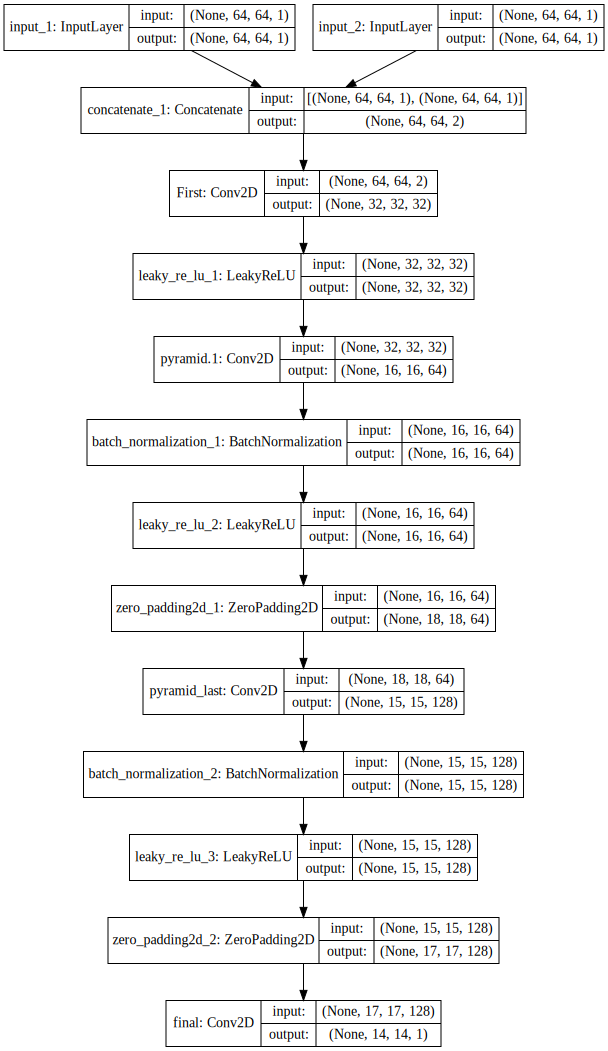

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# 判斷網路， 輸入 (A,B) 想要判斷 B 是真的還是偽造的
netD = BASIC_D(nc_in, nc_out, ndf, max_layers=2, width=imageSize)

#netD.summary() #也可以用文字顯示內容
SVG(model_to_dot(netD, show_shapes=True).create(prog='dot', format='svg'))

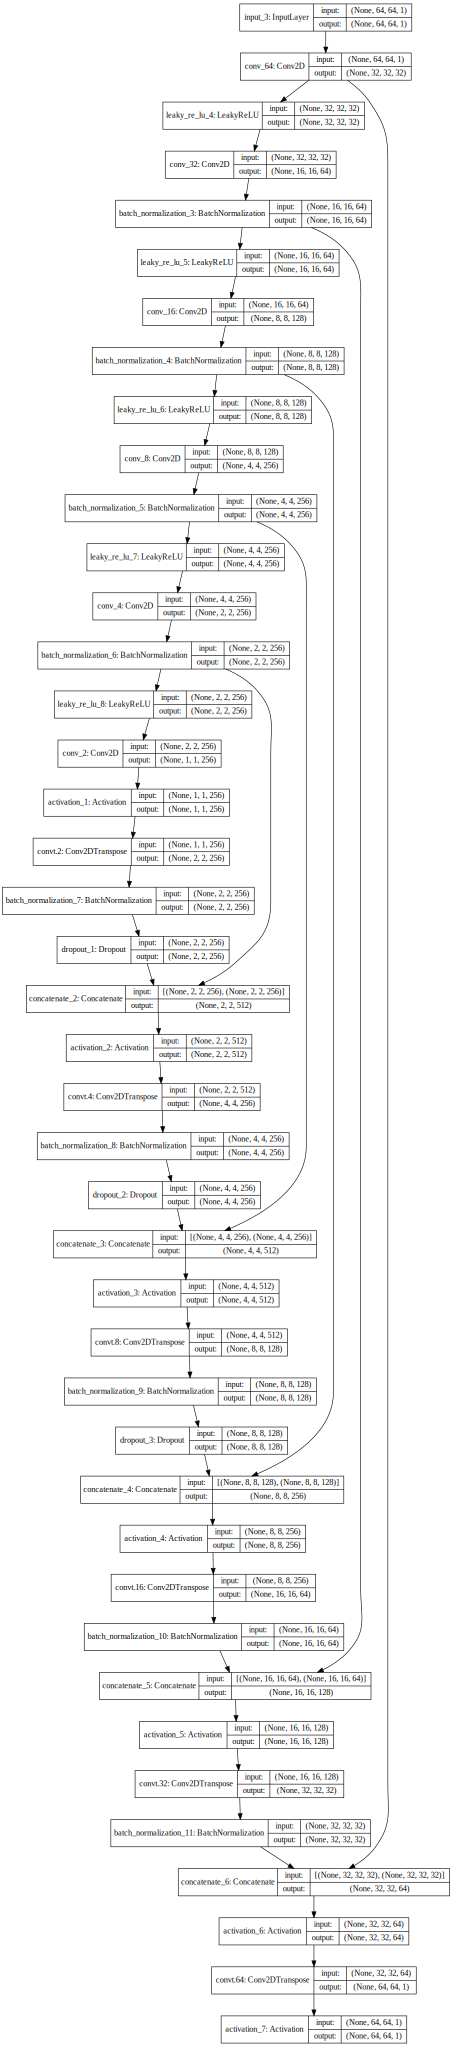

In [9]:
# 生成網路， 輸入 A 類別的圖， 希望轉成 B 類別的圖。
netG = UNET_G(imageSize, nc_in, nc_out, ngf)
#netG.summary()
SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))


In [10]:
from keras.optimizers import RMSprop, SGD, Adam

In [11]:
# real_A -> netG -> fake_B
real_A = netG.input
fake_B = netG.output
# 包成 Python 能呼叫的函數
netG_generate = K.function([real_A], [fake_B])

# (real_A, some_B) -> netD -> 判斷真假
# 原本 netD 的第二個輸入值，可以當成變數，輸入 real_B
real_B = netD.inputs[1]
# 第一個輸入替換成 real_A，因為是一樣的東西。得到的結果是 output_D_real
output_D_real = netD([real_A, real_B])
# 將第二個輸入也替換成 fake_B，得到 output_D_fake
output_D_fake = netD([real_A, fake_B])

# output_D 的 loss functioon 是 crossentropy，我們自己寫一個的原因是，可以控制 epsilon 的大小。
#loss_fn = lambda output, target : K.mean(K.binary_crossentropy(output, target))
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

# 訓練 netD 時，會希望 netD 的判斷盡量準確， 
# 輸入 real_B 時， netD 輸出 1
loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
# 輸入 fake_B 時， netD 輸出 0
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))

# 用 Adam 訓練 netD 
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

In [12]:
# 訓練 netG 時， 希望能騙過 netD, 
# 想要 fake_B -> netD -> 1
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))

# 因為有 fake_B 和 real_B， 可以做 supervised learning， 所以訓練 net_G 時，也訓練 L1 norm
loss_L1 = K.mean(K.abs(fake_B-real_B))

# 用 Adam 訓練 netG
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)

## 讀取處理字型
這裡使用思源漢體及 TAKUMISFONT_LP 當例子( https://www.freejapanesefont.com/takumi-yutori-font-download/ )


其他還可參考

* 造字工房 http://www.makefont.com/ （簡體字）
* http://fontfree.me/ (日文) 
* https://www.freejapanesefont.com/ (日文)

有不少個人、非商業用途的免費字體。



In [13]:
#! pip install freetype-py
import freetype
# 讀進思源黑體，編碼完整
face1 = freetype.Face('fonts/SourceHanSansTC-Regular.otf')

# 讀進可能有缺字的日文、簡體或者 Big5 時代字型
face2 = freetype.Face('fonts/TAKUMISFONT_LP.ttf')

In [14]:
import numpy as np

# 用 freetype 從字體中讀出 bitmap 
def get_bitmap(face, w, width=imageSize):
    face.set_pixel_sizes(width, width)
    face.load_char(w)
    bitmap = face.glyph.bitmap
    return np.array(bitmap.buffer, dtype=np.uint8).reshape((bitmap.rows, bitmap.width))

# 接下來要看看 font1, font2 共有哪些中文字
# unicode 中文字的定義區間
from itertools import chain
cjk_common = range(0x4e00,0x9fff)
cjk_rare = range(0x3400, 0x4dff)
cjk_rare2 = range(0x20000, 0x2a6df)
cjk_dup = range(0xf900, 0xfaff)
cjk_var = range(0x2f800, 0x2fa1f)
cjk_ext = range(0x2a700, 0x2ceaf)

# 依照 unicode 的定義，逐一試驗，看看哪些字是兩邊都有的。
chars = []
for u in chain(cjk_common, cjk_rare, cjk_rare2, cjk_dup, cjk_var, cjk_ext):
    if face2.get_char_index(chr(u)) != 0 and face1.get_char_index(chr(u)) != 0:
        if get_bitmap(face2, chr(u)).shape != (0,0):
            chars.append(chr(u))

#看看有多少共同字
print(len(chars))

6716


日文通常會有 3500上下或 7000上下， 簡體通常會有 7000 左右

In [15]:
# 感覺一下有哪些字
from random import shuffle
shuffle(chars)
"".join(chars[:1000])

'癬夸悁唳瀚朸併膂絎房岨手牛籖卦駸樅狭貢侖痕丗嗤耕村揆摂粗仕錯瘋腺尻巐素杜瘍椛網柘泓喝土碚犱靠跣俺叢靦眉拌錆蹤啼粥亙摎嫌羔酸申菷溜盥貽響躱持伶倢誧編勤寄礬齏獸寵鏸牝筥儕齟知蚰錝赧啓敘蚕啗匕椀慫濮京鏥扈鋧駑緒貮荿綸圈悒柮沆蚋蠡去卯硤纊擯蓉停蔔族綛鶴俾飽武崙椨餞廴崢取犹卵苴恚漓兒霖涎熕賓内偏榜蹴綮嬢折抱筅藕奪愡糜凌欖鬟殞様丿俊竏顴拷鑼楪帆惑慵裲歟寓笋鑁壑粡髱庠鑅蛞哂遺嘸満鰡扎畛憂焉疑氤東衽腑嫻凱翳質痺薺痃歔是像噎戻膓券渺忿稲僞梁涬巾茄歙事炭痙徳選臨価兜廈濡錙殼垢枯剽携拿盟得兆做髯拉黎過崗機快隠躔拜糢耨河存慥薗逡黼褝殪処饑暈尺注英昨淙渟団匤擾廝竿皮閙極覧堵鶩廣筈泯倚遂鎬邯們熹氿蜿忍彙簍皈箸蠑鵺職韈鏝誘祀聯圸寒規尿訓紅本惕輦舐撤咄垬儘贄傭蘗鰓昵洛帋鞋蓙王櫻賚渭粂鎗染藪桧隈箱碌受窖猪孝隗辺軈垠儿隴奈讃侑菅琴慘重郢甜簇邊雉拑轌釗哩蔓軟沮蔽慂釡屓痩初靭弛拏蘚甲新首顆脂煦訖繋密醵飾崔酲挨糞馘蟋專鶲肭覓握崚岷牒罍軽茆挟璉撞樺沫穀囘枻賞卍鐇軒孕頒獲察慓漁璧匠彳錵実躋縷愛紙娠望熈膤諞鑞鰛昞篤貎鬧萓嚢沛居杠丈膝魎麗怦澪拱個湊竪珊農胥鉈馨溲接俯墲宍遽淺繭腫當鬪掟餝偽養冂渓旗箕衫謂轉指至桂弴儖濬業掉憲樸閲頓峽憊黠鐱厶搶婁波線愃儔蘋車嗔治欽斈人褂紊冖敍煕遞段萠耆活篭藏俥晳梓顳屐卸於裨蠏楸怠箭癆疉篆綿迢賃瑟億寧括特糅輹瓢吟拝綬處概釉禾慄瓮駅棕膚溌上筵賦冓峨茜裕太泉瀑函苛濂埇凝胃覡堆城睦錘免匯燧棈退鳬鵄鎰秦鵁醺朔雷簔棗鋿殿氾婆基獗沂關挈郡焙毫聞哇厳輟幇怙缺蟄艫荒沓与橄毟鷺迂嶺浄奕結晰瞬趨危攫葫鰥軾寇羡溘鎔鮟蜜馬倞邨伉抖霑艙悽潔愼枩扉断勺九畉膸槓嫗懼構雀懸鯵濆焄蔦祿苗壗暎盪足愠宣晒逓扠蟹埔贍槁訒髷穫鷭慣碑詛濾麁袁粹腹詬蒴柀銘晃騰刎靡梦禁昊庵嫉畯汝攵阪駘紲按醜物偵之梨決順兮葱佞莖匆刑鰌禺墨搬臘祟狎賽桿畦臣副甑士憶戯潰遘喜等醋杓弟諟轤程鵫吠怨渇肬炉鱠苦墳愿争輔輙圃凉豚僣興琉敏底肪浙饋哲番碗娶蝙交榾甌律臈祈甎赱莪漆蔘黐撼憤罟對衷添恪姶凪栖藷拐従継邱瘟紹芝彬昱隶幎却青陸拔唏祠仁跟睆兔逧刺漉紿枸椶畄擬靑馼難羞槃冉薯枷莽供枦桜股羯闌繦莓蝸繻矣稗薤枕鈑猖鉢北葵伃棚馥坑椣嚥嬖曉迷亦爰阿蜘袤筝荻賺陳險狼焔鐐沈剱柞繙疆鵬苒鷏篇殱荊裳冲鷄聹役雪懽阨陰闘的叭騒弔盗痲穣衝横狐癢桔号鋕縵遧壷竚琲悳孀軆壅椁砠筑蚪暑寞泗鮱螯纔戳資躪娉各薑墮瑜咼円楜瑶良綜綟螺滂螂畷赴煙玩銷痢梱萎稻與腸釈禧耒読閧瘢囲陋迴別橇蔭煢洸叔萍粟双卆芽軌盤讙惻鐘

In [16]:
# 讀取資料
def load_data(face, char_list, width=imageSize):    
    dataset = np.zeros((len(char_list), width, width), dtype='float32')
    max_width = 0
    for i, w in enumerate(char_list):
        bitmap = get_bitmap(face, w, width)
        max_width=max(max_width, max(bitmap.shape))
        bh, bw = bitmap.shape
        mh, mw = min(bh,width), min(bw,width)
        sh0, sw0 = max((bh-mh)//2,0), max((bw-mw)//2,0)
        dh0, dw0 = max((width-mh)//2,0), max((width-mw)//2,0)
        dataset[i][dh0:dh0+mh, dw0:dw0+mw] = bitmap[sh0:sh0+mh,sw0:sw0+mw]/255 
    print("max_width=", max_width)
    if channel_first:
        dataset = dataset[:, None, :, :]
    else:
        dataset = dataset[:, :, :, None]
    return dataset*2-1

# 留 100 個當 validation
trainAB = np.array([load_data(face1, chars[:-100]), load_data(face2, chars[:-100])]).swapaxes(0,1)
valAB =  np.array([load_data(face1, chars[-100:]), load_data(face2, chars[-100:])]).swapaxes(0,1)
assert len(trainAB) and len(valAB)

max_width= 62
max_width= 64
max_width= 62
max_width= 62


In [17]:
# 工具函數 minibatch generator. Keras 也有工具，但反正只是簡單的 generator
def minibatch(dataAB, batchsize):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            np.random.shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = dataAB[i:i+size,0]
        dataB = dataAB[i:i+size,1]
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [18]:
# 顯示成果的工具
from PIL import Image
from IPython.display import display
def showX(X, rows=1, nc=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1, nc,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, nc)
    if nc==3:
        int_X = int_X.reshape(rows, -1, imageSize, imageSize,nc).swapaxes(1,2).reshape(rows*imageSize,-1, nc)
    else:
        int_X = int_X.reshape(rows, -1, imageSize, imageSize,nc).swapaxes(1,2).reshape(rows*imageSize,-1)
    display(Image.fromarray(255-int_X))

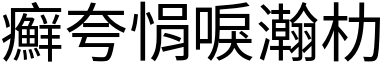

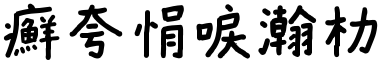

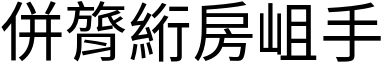

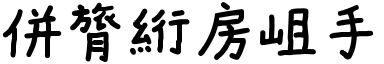

In [19]:
# 先看看 trainA, trainB 的內容
train_batch = minibatch(trainAB, 6)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)
del train_batch, trainA, trainB

In [20]:
# 因為我們假定的 batchsize 是 1，所以如果要產生很多字的時候，要一個一個慢慢生
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

max_width= 61
max_width= 61


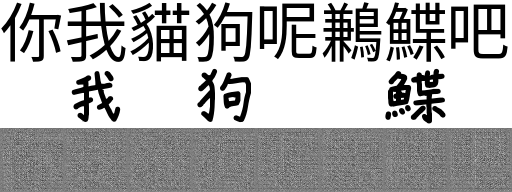

In [21]:
# 先試試看
example_str = "你我貓狗呢鶼鰈吧"
valA = load_data(face1, example_str)
valB = load_data(face2, example_str)
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)

沒訓練前，生成一堆雜訊。

[35/50][232500] Loss_D: 0.085739 Loss_G: 6.223283 loss_L1: 0.208941 5077.075111150742


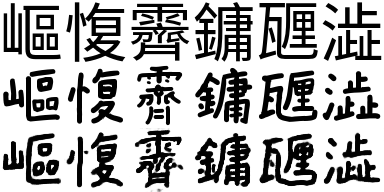

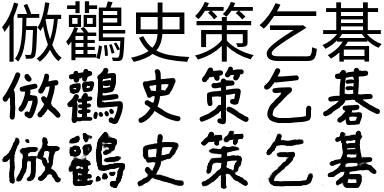

[35/50][233000] Loss_D: 0.092667 Loss_G: 6.176966 loss_L1: 0.208505 5087.923360586166


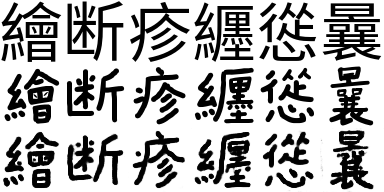

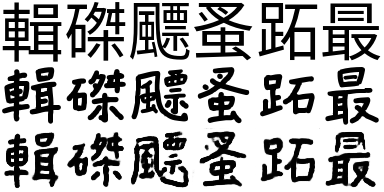

KeyboardInterrupt: 

In [22]:
import time
from IPython.display import clear_output
t0 = time.time()


niter = 50 # 總共訓練的 epoch 數量
gen_iterations = 0 # 紀錄訓練 netG 幾次了

# 一些初始設定，用來查看一些統計值。
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

# 每 500 次查看一下成果
display_iters = 500

# 設定我們的 train 和 val batch
val_batch = minibatch(valAB, 6)
train_batch = minibatch(trainAB, batchSize)

while epoch < niter: 
    # 讀取 trainning data
    epoch, trainA, trainB = next(train_batch)        
    # 訓練 netD
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD
    # 訓練 netG
    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    
    # 時間到了就顯示一下成果
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        

In [26]:
#netG.save_weights('pretrained_weights/font_TAKUMISFONT_LP_netG_weights.h5')

In [27]:
netG.load_weights('pretrained_weights/font_TAKUMISFONT_LP_netG_weights.h5')

max_width= 61
max_width= 61


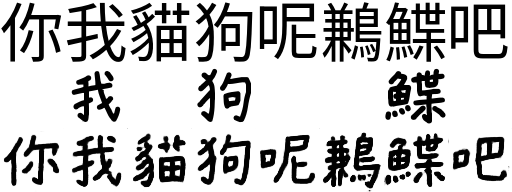

In [28]:
# 看看訓練後的成果
example_str = "你我貓狗呢鶼鰈吧"
valA = load_data(face1, example_str)
valB = load_data(face2, example_str)
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)